### Import Dependencies

In [2]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document

from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import instructor
import inspect
import json

from utils.utils import get_tool_descriptions, format_ai_message

#### Query Expansion (Parallel Execution)

In [3]:
class State(BaseModel):
    expanded_queries: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    question_relevant: bool = False
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

#### Query Expansion / Rewriting Node

In [4]:
class QueryExpandResponse(BaseModel):
    expanded_queries: List[str]

In [5]:
@traceable(
    name="expand_query_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def expand_query_node(state: State) -> dict:

    prompt_template = """
You are a helpful shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand a user's query into multiple queries that can be used to search for products in the database.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

    prompt = Template(prompt_template).render(query=state.initial_query)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_model=QueryExpandResponse,
        temperature=0.5
    )
    
    return {
        "expanded_queries": response.expanded_queries
    }    

In [6]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_queries:
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

#### Retriever Node

In [25]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding


@traceable(
    name="retrieve_top_n",
    run_type="retriever",
)
def retrieve_node(state: State) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search-v2",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(text=state["query"], model="Qdrant/bm25"),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"]
    )

    retrieved_context_ids = []
    retrieved_context= []
    similiarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload['parent_asin'])
        retrieved_context.append(result.payload['description'])
        similiarity_scores.append(result.score)
        retrieved_context_ratings.append(result.payload['average_rating'])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context]
    }

#### Aggregator Node

In [26]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="The final answer to the user's question")

In [27]:
@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)

def aggregator_node(state: State) -> dict:

    preprocessed_context =  "\n".join(state.retrieved_context)

    prompt_template = """
You are a helpful shopping assistant that can answer questions about products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and retured with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

<Question>
{{ question }}
"""

    template = Template(prompt_template)
    
    prompt = template.render(
        preprocessed_context=preprocessed_context,
        question=state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_model=AggregatorResponse,
        temperature=0.5
    )
    
    return {
        "answer": response.answer
    }    

### User Intent Router Node

In [ ]:
class IntentRouterResponse(BaseModel):
    question_relevant: bool
    answer: str

In [29]:
@traceable(
    name="intent_router_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def intent_router_node(state: State):

    prompt_template = """
You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to classify it into relevant or not relevant.
- If the question is not relevant, return False in field "question_relevant" and set "answer" to explain why it is not relevant.
- If the question is relevant, return True in field "question_relevant" and set "answer" to "".
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.

<Question>
{{ question }}
</Question>
"""

    template = Template(prompt_template)

    prompt = template.render(
        question = state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": prompt}
        ],
        response_model=IntentRouterResponse,
    )

    return {
        "question_relevant": response.question_relevant,
        "answer": response.answer
    }


In [30]:
def intent_router_conditional_edges(state: State):

    if state.question_relevant:
        return "expand_query_node"
    else:
        return "end"


#### Graph

In [31]:
workflow = StateGraph(State)

workflow.add_node("expand_query_node", expand_query_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)
workflow.add_node("intent_router_node", intent_router_node)

workflow.add_edge(START, "intent_router_node")

workflow.add_conditional_edges(
    "intent_router_node", 
    intent_router_conditional_edges,
    {
        "expand_query_node": "expand_query_node",
        "end": END
    }
)

workflow.add_conditional_edges(
    "expand_query_node",
    query_expand_conditional_edges
)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()


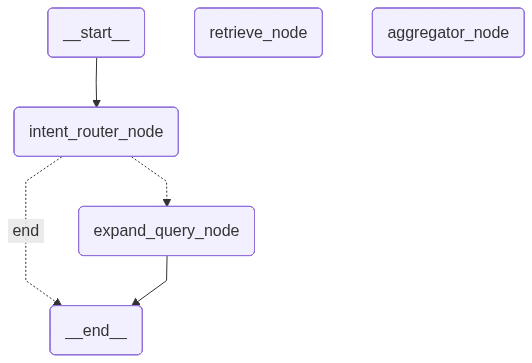

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
query = 'Can I get a tablet for my kid, a watch for my wife, and a laptop for myself?'
initial_state = {
    "initial_query": query
}
result = graph.invoke(initial_state)

In [35]:
result

{'expanded_queries': ['tablet for kids',
  'smartwatch for women',
  'laptop for personal use'],
 'retrieved_context': ['- ID: B0B4SN9K1T, rating: 3.5, description: Wainyok Kids Tablet, 7 inch Eye Protection IPS Screen, 2GB 16GB WiFi Tab, Dual Camera, Bluetooth & Kids-Proof Case Android11 Tablet. 【Perfect Tablet for Kids】 The kids edition tablet build-in high-performance quad-core processor and Android 11 system. offers access to a range of age-appropriate and up to date fun content including games, videos, paintings, and educational apps. It\'s an ideal Kid\'s gift for Christmas, Thanksgiving, birthday【High-end Configuration】 The full-featured tablets for kids receives good appraisal for its well-equipped components. The kid tablet is composed with quad core CPU, latest Android 11 system, 1024x600 IPS HD display screen, Wifi, Bluetooth, dual camera, touchscreen, 2GB RAM and 16GB ROM. Kids will get an all-in-one powerful device【Fantastic Experience】 This new version kids tablet will pr

In [36]:
print(result["answer"])

Based on the available products, here are options for a tablet for your kid, a watch for your wife, and a laptop for yourself:

Tablet for Kid:
- Model: Kids Tablet 7 inch Android 11 Tablet for Kids (Ages 2-10)
- RAM: 3GB
- Storage: 32GB ROM with 128GB expandable
- Screen: 7 inch, 1024x600 IPS HD display with eye protection
- Processor: Quad-Core
- OS: Android 11
- Features: Dual cameras (2MP+5MP), WiFi, Bluetooth, hotspot support
- Comes with pre-installed kid-friendly educational apps and games
- Protective shockproof case with adjustable stand included
- Warranty: 2 years

Watch for Wife:
- Model: Iaret Smart Watch for Women
- Screen: 1.32" HD full touch screen, resolution 360x360
- Features: Call receiving/dialing, AI voice assistant control, heart rate, blood pressure, blood oxygen monitoring, sleep tracker
- Sports modes: 20 sports modes including walking, running, cycling, swimming, yoga, tennis, golf
- Waterproof: Yes
- Battery: 230 mAh, 3-7 days usage
- Stylish design with ult

In [37]:
query_irrelevant = 'What is the weather in Tokyo?'
initial_state = {
    "initial_query": query_irrelevant
}
result = graph.invoke(initial_state)

In [38]:
result

{'retrieved_context': [],
 'question_relevant': False,
 'initial_query': 'What is the weather in Tokyo?',
 'answer': 'The question is about the weather in Tokyo, which is not relevant to the products in stock. I can only answer questions related to the products in stock.'}

In [39]:
print(result["answer"])

The question is about the weather in Tokyo, which is not relevant to the products in stock. I can only answer questions related to the products in stock.
